## Course Recommender System

*Abe Ravanshad*<br>
*012740585*<br>

This notebook covers my code for developing a `course recommender sysetm` (CRS) based on `Sequential Pattern Mining` (SPM) or `Itemset Mining`. We employ a pattern-growth algorithms called `FP-Growth` algorithm to detect frequent patterns. The main idea of pattern-growth algorithms is to reduce the cost of scanning the database by introducing the concept of `projected database` to explore larger itemsets with its depth-first search [1].
I could also use `prefixspan` algorithm which is one of the most efficient and widely used SPM algorithms. It is also employs the projected database concept but it only examines the prefix subsequences and project only their corresponding postfix subsequences into Projected databases [2]. 

Fortunately, I could find 2 python libraries with the implementation of these algorithms: `pyfpgrowth` and `prefixspan` [3][4][5]. However, I only use pyfpgrowth as it also generates the association rules that I can use for recommendation. Moreover, Spark MLlib has implementation of both algorithms that can be used for large datasets[6]. My dataset is not that large, so I didn't use Spark for this project.

You can find more information about the dataset and the methodolgy in the report.

1. [A Survey of Itemset Mining](http://www.philippe-fournier-viger.com/Survey_Itemset_Mining.pdf)
2. [Sequence-based Approaches to Course Recommender Systems](https://link.springer.com/chapter/10.1007/978-3-319-98809-2_3)
3. [prefixspan python](https://www.bbsmax.com/A/1O5Ev7GWd7/fp)
4. [pyfpgrowth Documentation](https://pypi.org/project/pyfpgrowth/)
5. [prefixspan Documentation](https://pypi.org/project/prefixspan/)
6. [Spark Frequent Pattern Mining](https://spark.apache.org/docs/latest/ml-frequent-pattern-mining.html)

### Required Libraries

In [1]:
import os, gc
import numpy as np 
import pandas as pd 
import pickle
import multiprocessing
import datetime, math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
color = sns.color_palette()
plt.rcParams['figure.figsize'] = [12, 6]
plt.style.use('seaborn-whitegrid')
matplotlib.rc('xtick', labelsize=11) 
matplotlib.rc('ytick', labelsize=11) 

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
from utility import *

### Read Data

In [6]:
DATA_PATH = '../../data/'
OUT_PATH = '../../output/'

data = pd.read_csv(DATA_PATH+'stdnt_grade_v3.csv', low_memory=False, encoding='ISO-8859-1', header=0)
data.sample(3)

,EMPLID,DEPARTMENT,MAJOR,SENIORITY,STRM,CRS_YEAR_TERM,CLASS_NBR,CRSE_ID,CRS_UNITS_TAKEN,CRS_SUBJECT_DESC,CRS_TITLE,CRS_COMPONENT,COURSE_COLLEGE,COURSE_DEPARTMENT,CRS_ENRL_CAP,CRS_TOT_CNT,OFFICIAL_GRADE,CUM_TERM
14306,10666825,Computer Engineering,Computer Engineering,d.Seniors,2174,20174,40403,1728,3.0,Computer Engineering,Microproc Design 1,SEM,Engineering,Computer Engineering,72,74,A,9
13592,9065342,Computer Engineering,Software Engineering,d.Seniors,2172,20172,26910,6575,3.0,Industrial/Systems Engr,Comp & Hum Interact,SEM,Engineering,Industrial & Systems Engineering,80,76,B,15
16300,10639070,Computer Engineering,Software Engineering,d.Seniors,2192,20192,27329,1740,3.0,Computer Engineering,Comptr Networks I,SEM,Engineering,Computer Engineering,60,50,B,15


In [7]:
#check size of dataset
data.shape

(16347, 18)

In [8]:
# check for missing values 
missing = missing_count(data)
missing

Your selected dataframe has 18 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
CRS_COMPONENT,2,0.0
OFFICIAL_GRADE,1,0.0


A few missing values. That's good!

before any preprocessing, let's create the course dictionary that maps course ID to course title.

In [9]:
temp = data[['CRSE_ID', 'CRS_TITLE']].drop_duplicates()
course_dict = {x[0]:x[1] for x in zip(temp.CRSE_ID, temp.CRS_TITLE)}

## Data Preprocessing

we are going to keep lecture courses only as we think they are more important.

In [10]:
data = data[data['CRS_COMPONENT']=='LEC']

We also ignore the first semester as it is maintained by the program

In [11]:
data = data[data.CUM_TERM != 1]

In [12]:
#let's check data size again
data.shape

(8217, 18)

In [13]:
#fix emplid format to 9 digits
data.loc[:,'EMPLID'] = data.loc[:,'EMPLID'].apply(lambda x: str(int(x)).rjust(9,'0'))

In [14]:
#create a new field, fill_ratio
data['fill_ratio'] = data['CRS_TOT_CNT']/data['CRS_ENRL_CAP']

Below shoes the fill_ratio distribution of all lecture classes. 

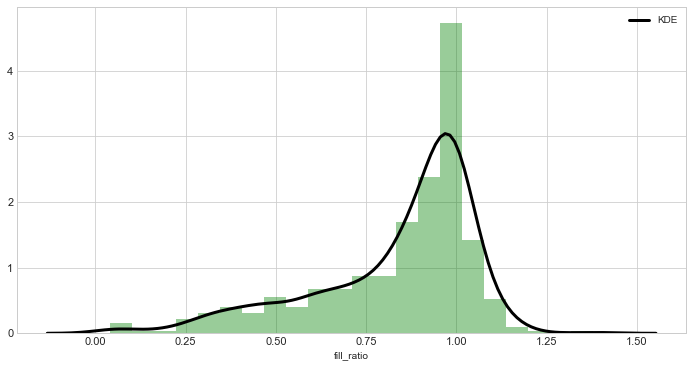

In [15]:
temp = data.groupby(["CRSE_ID"], as_index=False).mean()
ax = sns.distplot(temp['fill_ratio'], color="g", 
                  rug=False, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"})

It seems that most instructors are strict about the class capacity. Demanding courses with long waitlists can be added as a constraint to the problem. We do not consider that in our problem.  

In [16]:
#change data type
def to_str(df,col_list):
    for col in col_list:
        df[col] = df[col].astype(str)
    return df

data = to_str(data, ['EMPLID', 'STRM', ]) #'CRSE_ID'

There are a few summer courses. we remove them.

In [17]:
data = data[~data.STRM.isin(['2093', '2133'])]

In [18]:
#check the departments assigned to students
data.DEPARTMENT.value_counts()[:5]

Computer Engineering      3779
Humanities                3244
All University             477
Electrical Engineering     105
Computer Science            61
Name: DEPARTMENT, dtype: int64

students choose their major after a few semesters so it is reasonable to see this diversity. We assign the department to students based on their graduated department. Let's fix this.

In [19]:
#map department to the departement at the senirity level
temp = data[data['SENIORITY'] == 'd.Seniors'][['EMPLID','DEPARTMENT']].drop_duplicates()
dept_dict = dict(zip(temp['EMPLID'], temp['DEPARTMENT']))
data['DEPARTMENT'] = data['EMPLID'].map(dept_dict)

In [20]:
data.DEPARTMENT.value_counts()

Computer Engineering       4251
Humanities                 3938
Organization/Management      20
Name: DEPARTMENT, dtype: int64

In [21]:
#one student has a different behavior
fix = {'009592648':'Humanities'}
dept_dict.update(fix)
data['DEPARTMENT'] = data['EMPLID'].map(dept_dict)

In [22]:
#share of each department from the # of records
data.DEPARTMENT.value_counts()

Computer Engineering    4251
Humanities              3958
Name: DEPARTMENT, dtype: int64

In [23]:
#distribution of grades
from astropy.table import Table
temp = data['OFFICIAL_GRADE']
temp_cnt = temp.value_counts()
print(*Table(temp_cnt.values, names=temp_cnt.index))

 A    B    A-   B+   B-  C   A+  C+  C-  D   F   D+  D-  RD  WU  I   W 
---- ---- ---- ---- --- --- --- --- --- --- --- --- --- --- --- --- ---
1953 1446 1302 1088 627 549 403 401 157  89  62  62  19  17  17  13   4


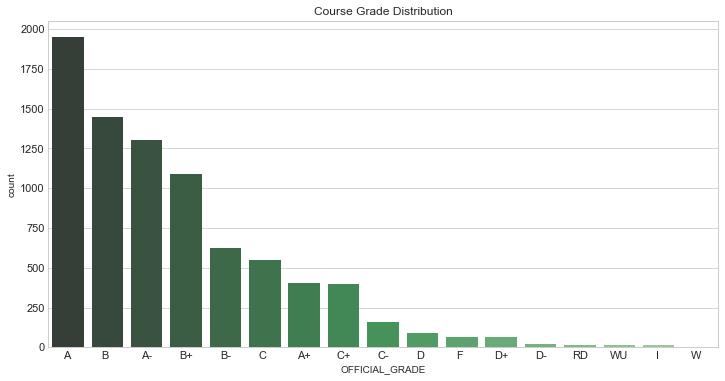

In [24]:
_ = sns.countplot(x='OFFICIAL_GRADE', data=data, palette="Greens_d", order=list(temp_cnt.index))
plt.title('Course Grade Distribution')
plt.savefig(OUT_PATH+'grade_dist.png', dpi=300)

we only want to find the `positive sequential patterns` of courses, i.e., sequences of courses taken by students with good outcome. `A+` and `A` are taken as `reference examples`. Note that a course deleted in one sequence may be selected in another sequence.

In [25]:
success = ['A ', 'A+']
filtered_data = data[data.OFFICIAL_GRADE.isin(success)]
filtered_data.shape

(2356, 19)

(0, 120)

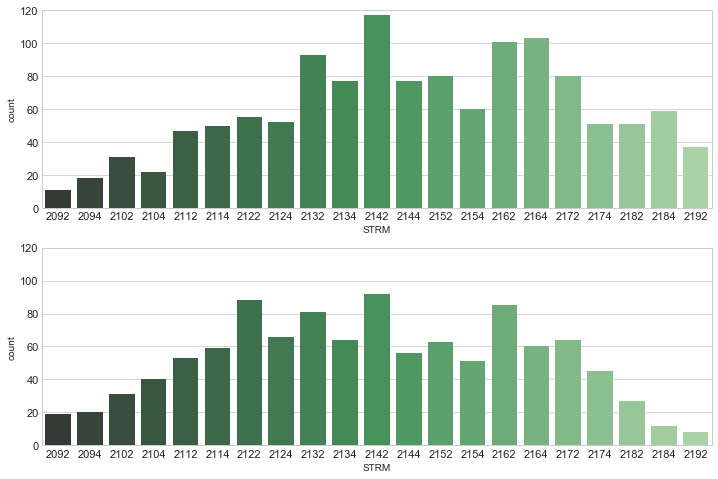

In [26]:
#distribution of positive records over time
temp1 = filtered_data[filtered_data.DEPARTMENT == 'Computer Engineering']
temp2 = filtered_data[filtered_data.DEPARTMENT == 'Humanities']
plt.figure(figsize=[12,8])
plt.subplot(2,1,1)
_ = sns.countplot(x='STRM', data=temp1, palette="Greens_d")
plt.ylim([0,120])
plt.subplot(2,1,2)
_ = sns.countplot(x='STRM', data=temp2, palette="Greens_d")
plt.ylim([0,120])

check total # of uniques students and unique courses in the 2 selected departments, Computer Engineering and Humanities, who have graduated less than 5 years. This includes courses taken after the 1st semester and students took A or A+ in them.


In [27]:
cols = ['EMPLID', 'CRSE_ID']
cnts = [len(np.unique(data[i])) for i in cols]
print('The unfiltered dataset has [{0}] of unique students and [{1}] unique courses.'.format(cnts[0], cnts[1]))

The unfiltered dataset has [404] of unique students and [531] unique courses.


In [28]:
cols = ['EMPLID', 'CRSE_ID']
cnts = [len(np.unique(filtered_data[i])) for i in cols]
print('The filtered dataset has [{0}] of unique students and [{1}] unique courses.'.format(cnts[0], cnts[1]))

The filtered dataset has [382] of unique students and [346] unique courses.


It seems that there are courses that no one took A or A+. This is one of the situations that suggests SPM is not the best method for this problem.

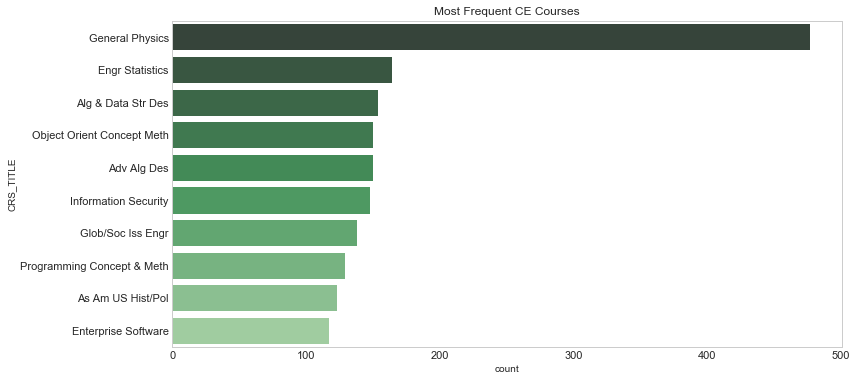

In [29]:
#courses with the most frequency and positive records in CE
temp = data[data.DEPARTMENT=='Computer Engineering']
_ = sns.countplot(y="CRS_TITLE", data=temp, palette="Greens_d",
              order=temp.CRS_TITLE.value_counts().iloc[:10].index)
plt.grid(False)
plt.title('Most Frequent CE Courses')
plt.savefig(OUT_PATH+'CE_Courses.png', dpi=300)

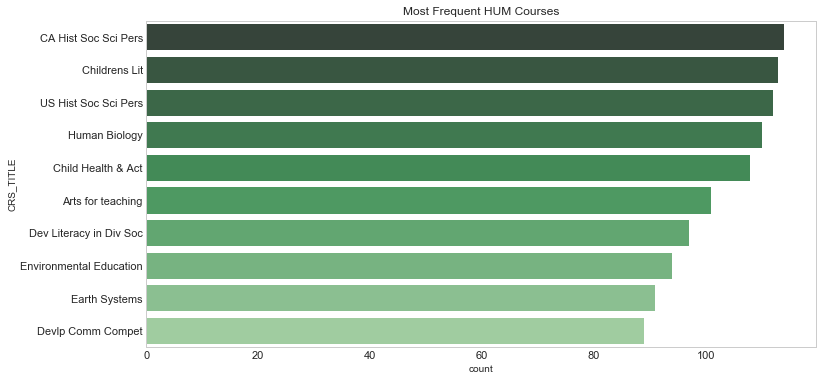

In [30]:
#courses with the most frequency and positive records in HUM
temp = data[data.DEPARTMENT=='Humanities']
_ = sns.countplot(y="CRS_TITLE", data=temp, palette="Greens_d",
              order=temp.CRS_TITLE.value_counts().iloc[:10].index)
# plt.xlim([0,500])
plt.grid(False)
plt.title('Most Frequent HUM Courses')
plt.savefig(OUT_PATH+'HUM_Courses.png', dpi=300)

Now, let's create itemsets for each student.

In [31]:
transactions = filtered_data.groupby("EMPLID")["CRSE_ID"].apply(list)
transactions = pd.DataFrame(transactions).reset_index(drop=False)
transactions.head()

,EMPLID,CRSE_ID
0,005959369,"[1936, 1974]"
1,005990985,"[8647, 1328, 7081, 10016, 12387, 6884, 10583, ..."
2,006002620,"[8293, 10583, 9413, 6080]"
3,006012604,"[10583, 1327, 5364, 8941, 3904, 12421]"
4,006029478,[255]


In [32]:
transactions['seq_length'] = transactions['CRSE_ID'].apply(len)

In [33]:
#number of transactions
len(transactions)

382

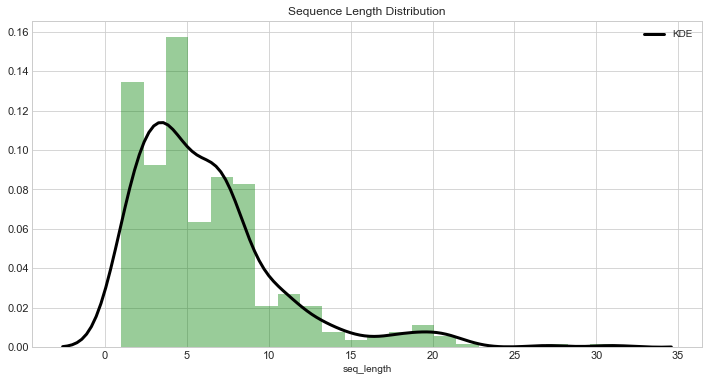

In [34]:
#distribution of sequence length
ax = sns.distplot(transactions['seq_length'], color="g", 
                  rug=False, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"})
plt.title('Sequence Length Distribution')
plt.savefig(OUT_PATH+'seq_len_dist.png', dpi=300)

In [35]:
#the longest sequence
np.amax(transactions['seq_length'])

31

One student from HUM department had a very successful track.

In [36]:
longest = transactions[transactions.seq_length>30]['EMPLID'].values.tolist()
data[data.EMPLID.isin(longest)][['EMPLID','DEPARTMENT']].drop_duplicates()

,EMPLID,DEPARTMENT
596,006575933,Humanities


We may want to apply some limit on the maximum pattern length to make the computation faster. From the practical point of view, it is more reasonable to avoid rare patterns. The distribution above suggests that max_length=15 might be reasonable. This makes the computation much much faster.

In [37]:
transactions = transactions[transactions.seq_length<=15]
transactions.shape

(363, 3)

## SPM

As briefly explained in the introduction, we'll find the frequent patterns and association rules based on 2 FP-Growth algorithm. This method are much more efficient than Apriori algorithm.

### Frequent Pattern Growth Algorithm

In [38]:
import pyfpgrowth

In [39]:
temp = transactions.iloc[:,1]

First, let's evaluate the 2 parameters we need to set for SPM: minimum support and confidence.

In [40]:
conf_range = list(np.arange(0.4,1,0.1))
min_sup_range = list(np.arange(2,6))
num_rules = [[] for _ in min_sup_range]

for i, s in enumerate(min_sup_range):
    patterns = pyfpgrowth.find_frequent_patterns(temp, s)
    for c in conf_range:
        rules = pyfpgrowth.generate_association_rules(patterns, c)
        num_rules[i].append(len(rules))

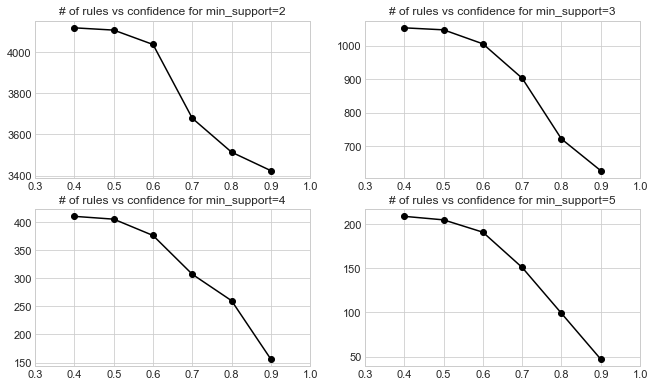

In [41]:
fig = plt.figure(figsize=[14,6])
for i in range(len(min_sup_range)):
    plt.subplot(2,2,i+1)
    plt.plot(conf_range, num_rules[i], '-o', c='k')
    plt.title("# of rules vs confidence for min_support="+str(i+2))
    plt.xlim([0.3,1])
    plt.ylabel
    
fig.subplots_adjust(
    hspace=.2,
    left = 0.2,
    right = 0.8,
    bottom = 0.1,
    top = 0.9 )

plt.savefig(OUT_PATH+'params.png', dpi=300)
plt.show()    

It seems that minimum support 2 and 70% confidence generates enough rules.

In [42]:
#find patterns that occur over the support threshold
temp = transactions.iloc[:,1]
min_sup = 2 #minimum threshold set for support count
patterns = pyfpgrowth.find_frequent_patterns(temp, min_sup)

In [43]:
len(patterns)

4679

let's find patterns that are associated with another with a certain minimum probability (we chose 0.7 here).

In [44]:
#generate association rules
rules = pyfpgrowth.generate_association_rules(patterns, 0.7)

In [45]:
#create rules dataframe
keys = [list(x) for x in rules.keys()]
values = [list(x[0]) for x in rules.values()]
confidence = [list(rules.values())[x][1] for x in range(0,len(rules))]
rules_df = pd.DataFrame({'lhs': keys, 'rhs':values, 'Confidence':confidence})

Let's calculate `Lift` for the generated rules. <br>
Given two items, A and B, lift indicates whether there is a relationship between A and B, or whether the two items are occuring together in the same orders simply by chance (ie: at random). 

 * lift = 1 implies no relationship between A and B. 
   (ie: A and B occur together only by chance)

 * lift > 1 implies that there is a positive relationship between A and B.
   (ie:  A and B occur together more often than random)

 * lift < 1 implies that there is a negative relationship between A and B.
   (ie:  A and B occur together less often than random)

In [46]:
rules_df['Merge'] = rules_df['lhs']+rules_df['rhs']

def support_count(ls):
    count = 0
    sls = set(ls)
    for j in transactions['CRSE_ID']:
        j = set(j)
        if(sls.issubset(j)):
            count += 1
    return count

lhs_support = []
for i in rules_df['lhs']:
    a = support_count(i)
    lhs_support.append(a/len(transactions))
    
    
rhs_support = []
for i in rules_df['rhs']:
    a = support_count(i)
    rhs_support.append(a/len(transactions))
    
support = []
for i in rules_df['Merge']:
    a = support_count(i)
    support.append(a/len(transactions))
    
rules_df['lhs_Support'] = lhs_support
rules_df['rhs_Support'] = rhs_support
rules_df['Support'] = support

# rules_df['Lift'] = rules_df['Confidence'] / rules_df['rhs']
rules_df['Lift'] = rules_df['Support'] / (rules_df['lhs_Support']*rules_df['rhs_Support'])

In [47]:
rules_df = rules_df.drop(columns=['Merge','lhs_Support','rhs_Support']) 

In [48]:
rules_df.sample(4,random_state=19)

,lhs,rhs,Confidence,Support,Lift
1969,"[5364, 5563, 8941, 10583, 10586]","[10033, 10584, 10585]",1.0,0.00551,51.857143
2338,"[7045, 10033, 10584, 10587]","[5563, 10583]",1.0,0.00551,25.928571
2065,"[1343, 5364, 5563, 8941, 10033, 10583, 10585]",[10586],1.0,0.00551,24.200000
2763,"[1838, 5563, 10583, 10585]","[5364, 10033]",1.0,0.00551,13.961538


In [49]:
#number of rules w positive relationship
rules_df[rules_df.Lift>1].shape[0]

3679

It seems that the generated associations are very strong. No random association!

Let's plot support and lift for the generated rules.

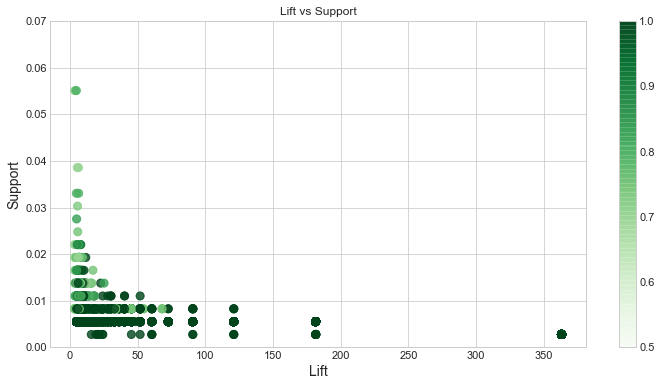

In [50]:
cm = plt.cm.get_cmap('Greens')
sc = plt.scatter(rules_df.Lift, rules_df.Support, 
                 c=rules_df.Confidence, vmin=0.50, vmax=1.0,
                 cmap=cm, alpha=0.8, s=65)
plt.colorbar(sc)
# plt.xlim([0,2.1])
plt.ylim([0,0.07])
plt.xlabel("Lift", fontsize=14)
plt.ylabel("Support", fontsize=14)
# plt.grid(False)
plt.title('Lift vs Support')
plt.savefig(OUT_PATH+'lift_support.png', dpi=300)
plt.show()

As said above, we see all rules have positive relationship which means many of these combinations did not happen by chance.

Now, let's create a recommender function that returns next courses by giving priority to the longest common elements with the student current course history.

In [51]:
import operator, itertools
import heapq

def set_diff(first, second):
    r'''finds the unique items in the first set
    that do not exist in the second set'''
    second = set(second)
    return [item for item in first if item not in second]

def merge_listoflist(listOflist):
    r'''merges list of list elements and removes duplicates'''
    return list(set(itertools.chain.from_iterable(listOflist)))
    
    
def recom(rules, new_set):
    r'''given associative rules, it returns the top k items
    by giving higher rank to the longer found patterns'''
    keys = [list(x) for x in rules.keys()]
    values = [list(x[0]) for x in rules.values()]
    recom_dict = {}
    for ix, k in enumerate(keys):
        if set(k).issubset(new_set):
            num = len(set(k))
            if num in recom_dict.keys():
                recom_dict[num].append(set_diff(values[ix], new_set))
            else:
                recom_dict[num] = [set_diff(values[ix], new_set)]
    recom_dict = {k: merge_listoflist(v) for k, v in recom_dict.items()} 
    result = sorted(recom_dict.items(), key=operator.itemgetter(0), reverse=True)[:5]
    if result[0][1] == []:
        return 'No Recommendation!'
    else:
        return [course_dict[x] for x in result[0][1]]

let's run a few test

In [52]:
new_set = set([8647, 1328, 7081, 10016, 12387, 6884, 5364, 8941, 3904])
recom(rules,new_set)

['CA Hist Soc Sci Pers']

In [53]:
data.STRM = data.STRM.astype(int)

In [54]:
temp = data[(data.EMPLID == '009954412') & (data.STRM <= 2184)]
a = temp.groupby('EMPLID')['CRSE_ID'].apply(list)[0]
[course_dict[x] for x in a]

['The Living World',
 'Intro to Data Strc',
 'General Physics',
 'Data Struct & Alg',
 'General Physics',
 'Engr Statistics',
 'Information Security',
 'Enterprise Software',
 'Glob/Soc Iss Engr']

In [55]:
recom(rules, a)

['Progrmng Paradigms']

### Clustering

In [56]:
DATA_PATH = '../../data/'
data = pd.read_csv(DATA_PATH+'clustering.csv', low_memory=False, encoding='ISO-8859-1', header=0)
data.sample(3)

,EMPLID,COHORT_YEAR_TERM,DEGREE_YEAR_TERM,TIME_TO_DEGREE,COHORT_COLLEGE,COHORT_DEPARTMENT,COHORT_CONCENTRATION,COHORT_ETHNICITY,COHORT_GENDER,COHORT_URM,COHORT_PELL,ENROLL_RESIDENT_STATUS,FIRST_GENERATION,ATHLETICS,DEGREE_TOTAL_UNITS,DEGREE_CAMPUS_GPA,DEGREE_TOTAL_GPA,HS_GPA,SAT_COMP,FIRST_TERM_GPA
32,10485982,20154,20192,3.75,Engineering,Computer Engineering,Software Engineering,Other,Female,Non-URM,Non-PELL,CA Res Non-Local,N,N,128.0,3.54,3.46,4.00,1050.0,3.530
228,9734114,20144,20192,4.75,Engineering,General Engineering,Engineering,Asian,Male,Non-URM,PELL,CA Res Non-Local,N,N,141.0,3.13,3.13,3.66,1080.0,2.675
242,10426416,20154,20192,3.75,Engineering,Computer Engineering,Software Engineering,Asian,Male,Non-URM,Non-PELL,CA Res Local,N,N,144.0,3.69,3.69,3.13,1250.0,4.000


In [57]:
missing_count(data)

Your selected dataframe has 20 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
ATHLETICS,283,70.0
SAT_COMP,26,6.4


In [58]:
ls = ['HS_GPA', 'SAT_COMP', 'FIRST_TERM_GPA']
for col in ls:
    cond = data[col]==0
    data[col] = np.where(cond, data[col].mean(), data[col])

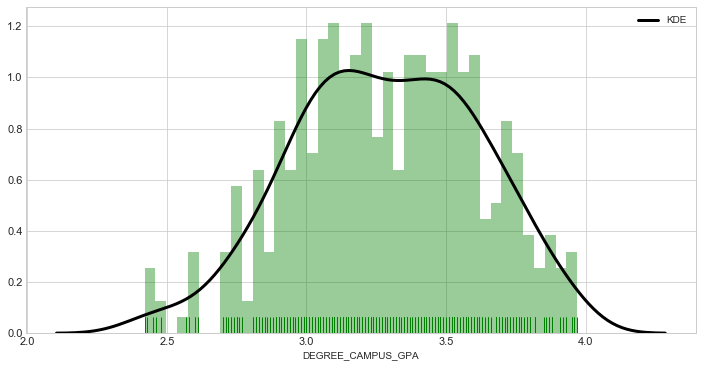

In [59]:
ax = sns.distplot(data.DEGREE_CAMPUS_GPA.dropna(), color="g", bins=40,
                  rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"})

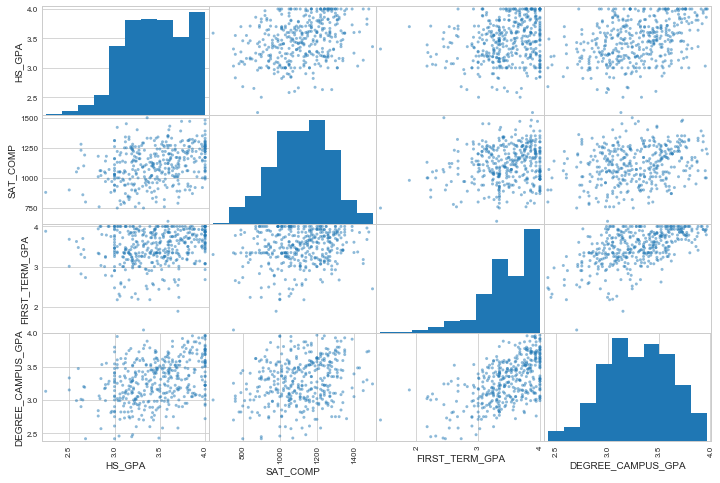

In [60]:
from pandas.plotting import scatter_matrix

_ = scatter_matrix(data[ls+['DEGREE_CAMPUS_GPA']], figsize=(12, 8))

In [61]:
X = data[ls].fillna(data[ls].median())

In [62]:
from sklearn.decomposition import PCA
import visuals as vs
pca = PCA(n_components=2).fit(X)

print ("variance in the data explained by first two pcs:", \
pca.explained_variance_ratio_.cumsum()[0])
print ("variance in the data explained by first four pcs:", \
pca.explained_variance_ratio_.cumsum()[1])

variance in the data explained by first two pcs: 0.9999868495854858
variance in the data explained by first four pcs: 0.9999951866483346


correlated features! Not descriptive features!